# K-nearest neighbours
K-nearest neighbours (KNN) is a supervised classification algorithm which works by looking at neighbouring points in the dataset to classify new unknown data points. Or to put it in another way, if you were to plot the data in a graph, points that are close together will probably have the same label. The K in the name stands for the number of nearest neighbours to consider for making the classification.

A trained KNN model basically consists of the training data since the classification is done by comparing the known data to the new data. However, since the model goes through all of the training data for every prediction, this can make these models slow if the training data is large.

The excellent Scikit Learn package has prebuilt functions available to use, so we don't actually need to do much programming at all.

## Learning Objectives

Average time to complete: 60min

By the end of this tutorial, you should be able to:
* Apply the KNN algorithm to various datasets
* Use visualization techniques to explore the data
* Use one-hot encoding
* Improve the model using hyperparameter tuning
* Appreciate the limits of the algorithm
* Impute data using fixed value replacement or linear regression

## What you will need for this tutorial

* See the [introduction document](https://uottawa-it-research-teaching.github.io/machinelearning/) for general requirements and how Jupyter notebooks work.
* We'll need Pandas for convenient data handling. It's a very powerful Python package that can read CSV and Excel files. It also has very good data manipulation capabilities which come in use for data cleaning.
* We will use scikit-learn as our machine learning package.
* The data files that should have come with this notebook.

## RDM best practices

Good data handling for machine learning begins with good Research Data Management (RDM). The quality of your source data will impact the outcome of your results, just like the reproducibility of your results will depend on the quality of your data sources, in addition to how you organize the data so that other people (and machines!) can understand and reuse it. 

We also need to respect a few research data management best practices along the way, these best practices are recommended by the [Digital Research Alliance of Canada](https://zenodo.org/records/4000989).

SAVE YOUR RAW DATA IN ORIGINAL FORMAT
* Don't overwrite your original data with a cleaned version.
* Protect your original data by locking them or making them read-only.
* Refer to this original data if things go wrong (as they often do).

BACKUP YOUR DATA
* Use the 3-2-1 rule: Save three copies of your data, on two different storage mediums, and one copy off site. The off site storage can be OneDrive or Google drive or whatever your institution provides.
* We are using Open Data, so it does not contain any personally identifiable data or data that needs to be restricted or protected in any way. However, if your data contains confidential information, it is important to take steps to restrict access and encrypt your data.

There are a few more RDM best practices that will help you in your project management, and we will highlight them at the beginning of each tutorial. 

The first step here is to import the packages that we need. As mentioned, we'll use Pandas and SciKit Learn. We'll also import NumPy which has some nice helper functions available. We'll also import the Seaborn plotting library which will help us visualize the data.


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pandas as pd
import numpy as np
import seaborn as sns

# Penguins
Since this is a supervised learning algorithm, we need a data set to train on that is already labelled. One popular dataset to explore this technique with is the Palmer Penguins dataset that is available on [CRAN](https://cran.r-project.org/web/packages/palmerpenguins/index.html). It contains measurement of various physical properties of different species of penguins. It's a nice data set because it works with only two features which means it's easy to plot in 2D. It's included in the Seaborn plotting library so we don't need to download it separately.

We'll just drop the rows with missing data since we have enough data to train the algorithm. Normally, you'd want to try to fill in the missing data as best as you can like we did before for the bike/weather data set in the tutorial about linear regression, but for the sake of simplicity and because we have enough complete rows, we will continue without fixing missing data.

In [2]:
penguins = sns.load_dataset('penguins').dropna()

In [3]:
penguins

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
4    Adelie  Torgersen            36.7           19.3              193.0   
5    Adelie  Torgersen            39.3           20.6              190.0   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe            47.2           13.7              214.0   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2         3250.0  Female  
4         3450.0  Female  
5         3650.0    Male  
..           ...     ...  
338       4925.0  Female  
340       4850.0  Female  
341       5750.0    Male  
342       5200.0  Female  
343       5400.0    Male  

[333 rows x 7 columns]

To make sense of the data and to see if KNN could be effective, we will want to plot the data. As mentioned before, KNN works by looking at neighbouring points for its classification predictions, so we will want to make a plot of one feature against another to see if there are distinct regions.

The Seaborn plotting library has a nice plotting function called "pairplot" which does exactly that. We make a pair plot of the bill dimensions and colour by species. This shows that there is indeed a relatively good split because you can clearly see the distinct regions. Remember that KNN labels unknown data points based on proximity to known data points.

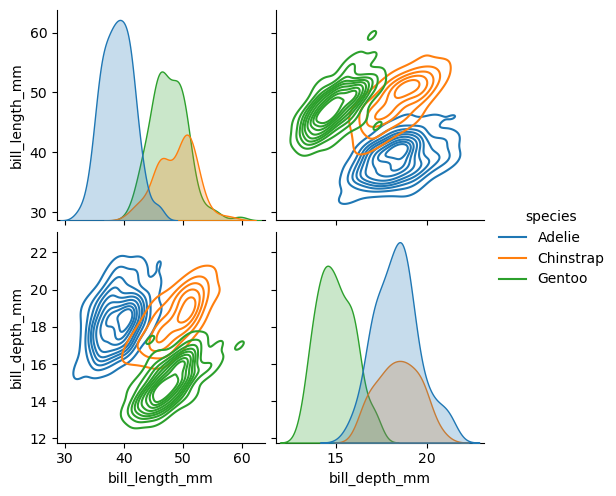

In [4]:
sns.pairplot(penguins[['bill_length_mm', 'bill_depth_mm', 'species']], hue='species', kind='kde')

The top-left and bottom-right plot show the distribution of a single feature in the dataset. For example, you can see from the bottom-right plot that the Gentoo penguin has a bill depth of around 15 mm while the Chinstrap and Adelie penguins have larger bill depths of about 18 mm.

The other two plots is what we are most interested in at the moment. They show one feature versus another. In this case bill length versus bill depth.

As an aside, the bottom-left plots is just the transpose of the top-right plot. It might not make sense to plot both in this case, but later we will see larger pair plots which will plot more than just two features it just makes them more readable.

From the bottom-left plot, we can see right away that clusters appear without even using the other data fields so we should be able to train a decent model without using any other features at all.

Of course we want to test how good our model is, so will do what we did in the tutorial about linear regression which is to split our data in a training and test dataset.

In [5]:
X = penguins[['bill_length_mm', 'bill_depth_mm']]
y = penguins['species']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

We now have a training set `X_train, y_train` (70% of the data) and a test set we can use for validation afterwards, `X_test, y_test` (remaining 30% of the data). The `shuffle` parameter randomizes the order of the rows and `random_state` makes the randomization always give the same for every run of this notebook, making it more reproducible.

From sklearn we can use the `KNeighborsClassifier` and specify any parameter we want. Let's use $k=4$ where $k$ is the number of nearest neighbours the algorithm should take into account.

In [7]:
neigh = KNeighborsClassifier(n_neighbors=4)

Then we fit this to the training data.

In [8]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

Let's see how well we did. There are many tests for quantifying the quality of the model. One of the most straightforward ones is a direct comparison between what the model predicts and what we know is the real class.

The test data that we separated out earlier in `X_test` and `y_test` is exactly what we need for that since for every row in `X_test`, we know what the real class is from the corresponding element in `y_test`. So all we need to do is put `X_test` in our trained KNN model and compare the output to `y_test`. We then count the number of times it got it right and divide by the total number of rows we test to get an accuracy score.

We can make a prediction using the `predict` method using our test input and then use the helper function `accuracy_score` to get the aforementioned accuracy score.

In [9]:
y_pred = neigh.predict(X_test)

In [10]:
accuracy_score(y_test, y_pred)

0.94

So we got a 94% accuracy. That is not bad at all! This means it's correct about 19 out of 20 times. Whether that is a good enough accuracy depends on what application of the model is meant for. For classifying penguins it's probably great. For medical diagnosis, it's kind of terrible. Good thing we are just dealing with penguins here!

We don't have to stick with two dimensions for the input even though that makes it a lot easier to visualize things as you can actually see the clusters in a plot in the case of the penguins. Once you get to input dimensions higher than 3 however, plotting things becomes harder because you run out of axes to plot against. That is with two features you can make a graph, with three you can make a 3D plot, but then what?

Let's see what happens when we add more features to train on. We'll only use the numerical features since categorical data requires a bit more work which we will get to later.

In [11]:
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = penguins['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.74

Oh no! Our accuracy is only 74% now. It dropped a lot. What happened here?

Let's look at the pair plots which is the best thing you can do for plotting high-dimensional data. Before we had a pair plot of just two features but now we'll have four. A pair plot will plot a grid of plots. The off-diagonal ones have one feature plotted versus each another feature. The diagonal ones show the distribution of a single feature. This sometimes lets you see clearly which combination of features are good for classifying.

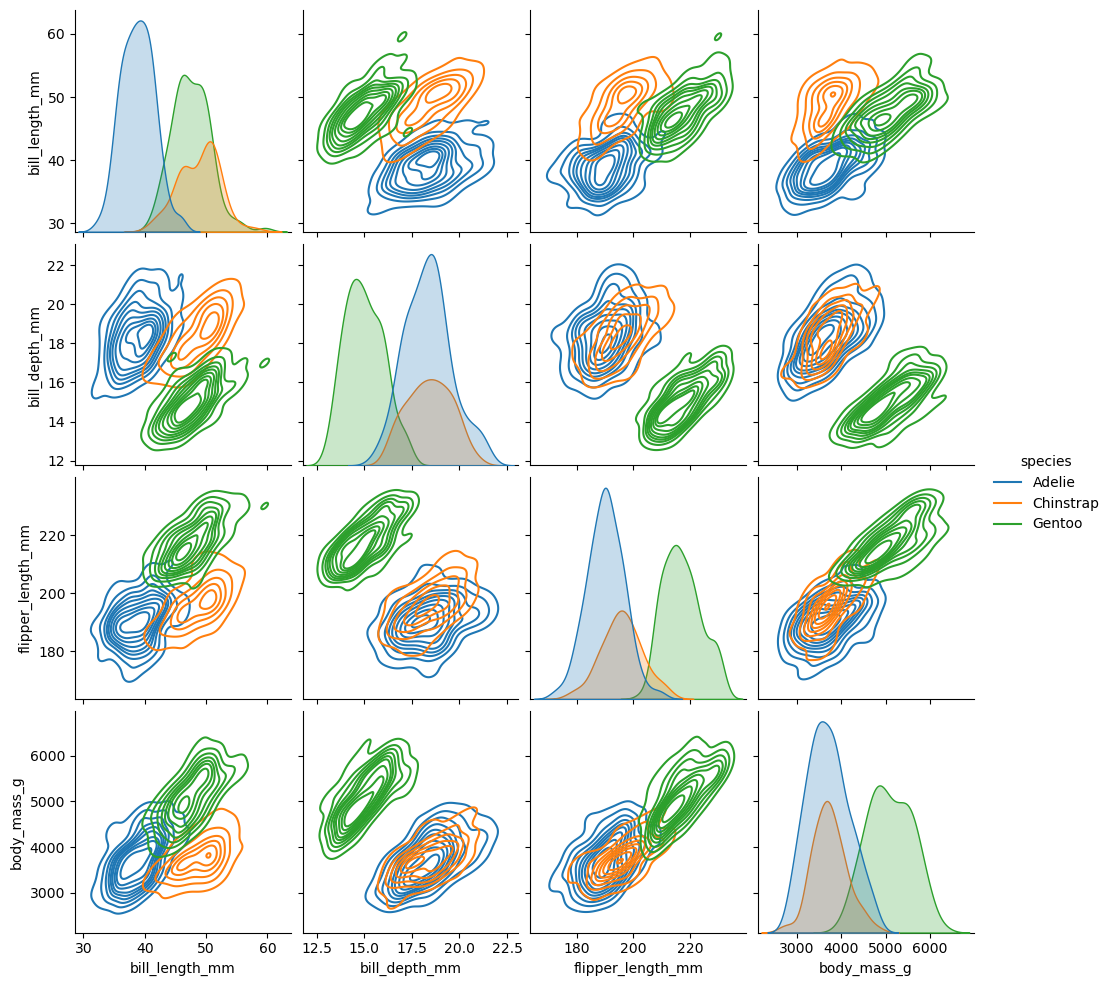

In [12]:
sns.pairplot(penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'species']], hue='species', kind='kde')

We see that there is an awful lot of mixing going on for Adelie and Chinstrap penguins. For example, `body_mass_g` and other `bill_depth_mm` and `flipper_length_mm` don't work well.

Additionally, body_mass_g has a much larger number range than the other properties. This is bad because KNN works by looking at the closest neighbours. It does this by measuring distance between points. However, if one dimension has large numbers and the other small numbers, this will make the dimension with the larger numbers have an outsized effect on the distance.

For example, if you look at body_mass_g then 4000 and 4050 would be considered close-by with a difference of just 50. However, if you look at bill_depth_mm, then a difference of 50 is huge since that data only ranges from 12.5 to 22.5.

Therefore, it is usually a good idea to modify the scale of each column of the data such that all data columns are in similar ranges to prevent this sort of issues. This is called normalization. Sklearn comes with just such a tool, `MinMaxScaler`! It maps the data to a range between 0 and 1.

Let's implement that and do our training again.

In [13]:
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = penguins['species']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.99

There we go! We now have 99% accuracy!

We still haven't used all of the data though. There are still the islands and the sex. However, those aren't numbers so how do you calculate distances there? It's maybe clear for sex since we have only female and male, so we could assign 0 and 1 to that.

In [14]:
penguins.sex = penguins.sex.replace({"Female": 0, "Male": 1})
penguins.head()

/tmp/ipykernel_20623/1235691974.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  penguins.sex = penguins.sex.replace({"Female": 0, "Male": 1})


species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g  sex  
0       3750.0    1  
1       3800.0    0  
2       3250.0    0  
4       3450.0    0  
5       3650.0    1

but there are three islands in our dataset:

In [15]:
set(penguins['island'])

{'Biscoe', 'Dream', 'Torgersen'}

We could assign 0 to Biscoe, 1 to Dream and 2 to Torgersen, but that would make Biscoe and Torgersen "further" away from each other than Biscoe and Dream. That's not right.

One way around this is to use one-hot vectors. These are vectors that have all zeroes except for one entry which is one. Instead of assigning a number to an island, we assign a vector.

$$
Biscoe = \begin{bmatrix}
           1 \\
           0 \\
           0
         \end{bmatrix},
Dream = \begin{bmatrix}
           0 \\
           1 \\
           0
         \end{bmatrix},
Torgersen = \begin{bmatrix}
           0 \\
           0 \\
           1
         \end{bmatrix}
$$

This translates into using the island column to generate three separate columns, one for each island with either 0 or 1. The Pandas library can do this for us automatically using the `pd.get_dummies` method.

In [16]:
pd.get_dummies(penguins['island'])

Biscoe  Dream  Torgersen
0     False  False       True
1     False  False       True
2     False  False       True
4     False  False       True
5     False  False       True
..      ...    ...        ...
338    True  False      False
340    True  False      False
341    True  False      False
342    True  False      False
343    True  False      False

[333 rows x 3 columns]

It shows `True` and `False`, but that's the same as 1 and 0 for computers.

The next steps is that we need to take those columns and join those to the original dataset.

In [17]:
penguins = penguins.join(pd.get_dummies(penguins['island']))
penguins

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
4    Adelie  Torgersen            36.7           19.3              193.0   
5    Adelie  Torgersen            39.3           20.6              190.0   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe            47.2           13.7              214.0   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g  sex  Biscoe  Dream  Torgersen  
0         3750.0    1   False  False       True  
1         3800.0    0   False  False       True  
2         3250.0    0   False  False       True  
4         3450.0    0   False  False       True  
5         3650.0    1   False  False       True  
..           ...  ...     ...    ...        ...  
338       4925.0    0    True  False      False  
340       4850.0    0    True  False      False  
341       5750.0    1    True  False      False  
342       5200.0    0    True  False      False  
343       5400.0    1    True  False      False  

[333 rows x 10 columns]

Our data is now all numerical. Let's try that again!

In [18]:
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'Biscoe', 'Dream', 'Torgersen']]
y = penguins['species']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.99

Well, our accuracy did not increase more, but it's hard to beat 99% accuracy since our test data set only has 100 data rows, so it only got 1 wrong. Still, we are now using all of our features to train the model.

# Diabetes

Let's use a less clean dataset this time. The penguins one was cleaned up thoroughly beforehand. It did have some missing values, but we simply dropped those.

One such dataset is the Pima Indian Diabetes Dataset, originally from the National Institute of Diabetes and Digestive and Kidney Diseases, which contains information of 768 women from a population near Phoenix, Arizona, USA. It can be used to predict diabetes.

It's a bit messier because it contains more missing data than the penguins one.

In [19]:
# From https://github.com/npradaschnor/Pima-Indians-Diabetes-Dataset
diabetesdata = pd.read_csv('../data/MLTS_20241205_KNN_diabetes_1.0.csv')
diabetesdata

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

Notice all the zeros in the SkinThickness column. I'm pretty sure most people have a skin thickness of more than 0 μm. Having no insulin is probably also very bad for your health, so this means that it must be missing data where they simply used 0 instead of indicating the data was missing with "N/A" for example.

We can count how many zeros there are in each column by using Pandas to select the rows with zeros and then counting them with sum.

In [20]:
print("Number of zeros")
print('Glucose:', sum(diabetesdata['Glucose'] == 0))
print('BloodPressure:', sum(diabetesdata['BloodPressure'] == 0))
print('SkinThickness:', sum(diabetesdata['SkinThickness'] <= 0.0001))
print('Insulin:', sum(diabetesdata['Insulin'] == 0))
print('BMI:', sum(diabetesdata['BMI'] <= 0.0001))
print('DiabetesPedigreeFunction:', sum(diabetesdata['DiabetesPedigreeFunction'] == 0))
print('Age:', sum(diabetesdata['Age'] == 0))

Number of zeros
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11
DiabetesPedigreeFunction: 0
Age: 0


That's a lot of missing data for insulin as well as for skin thickness. Anyway, let's replace these with our trusty NaN (not a number) to indicate it's a missing value. Otherwise the model will consider 0 to be an actual value which it is not.

In [21]:
diabetesdata.replace(
    to_replace={'Glucose': 0, 'BloodPressure': 0, 'SkinThickness': 0, 'Insulin': 0, 'BMI': 0},
    value=np.nan,
    inplace=True
)

Let's look at the pair plot again. KNN likes very distinct regions. Let's see if we can spot any!

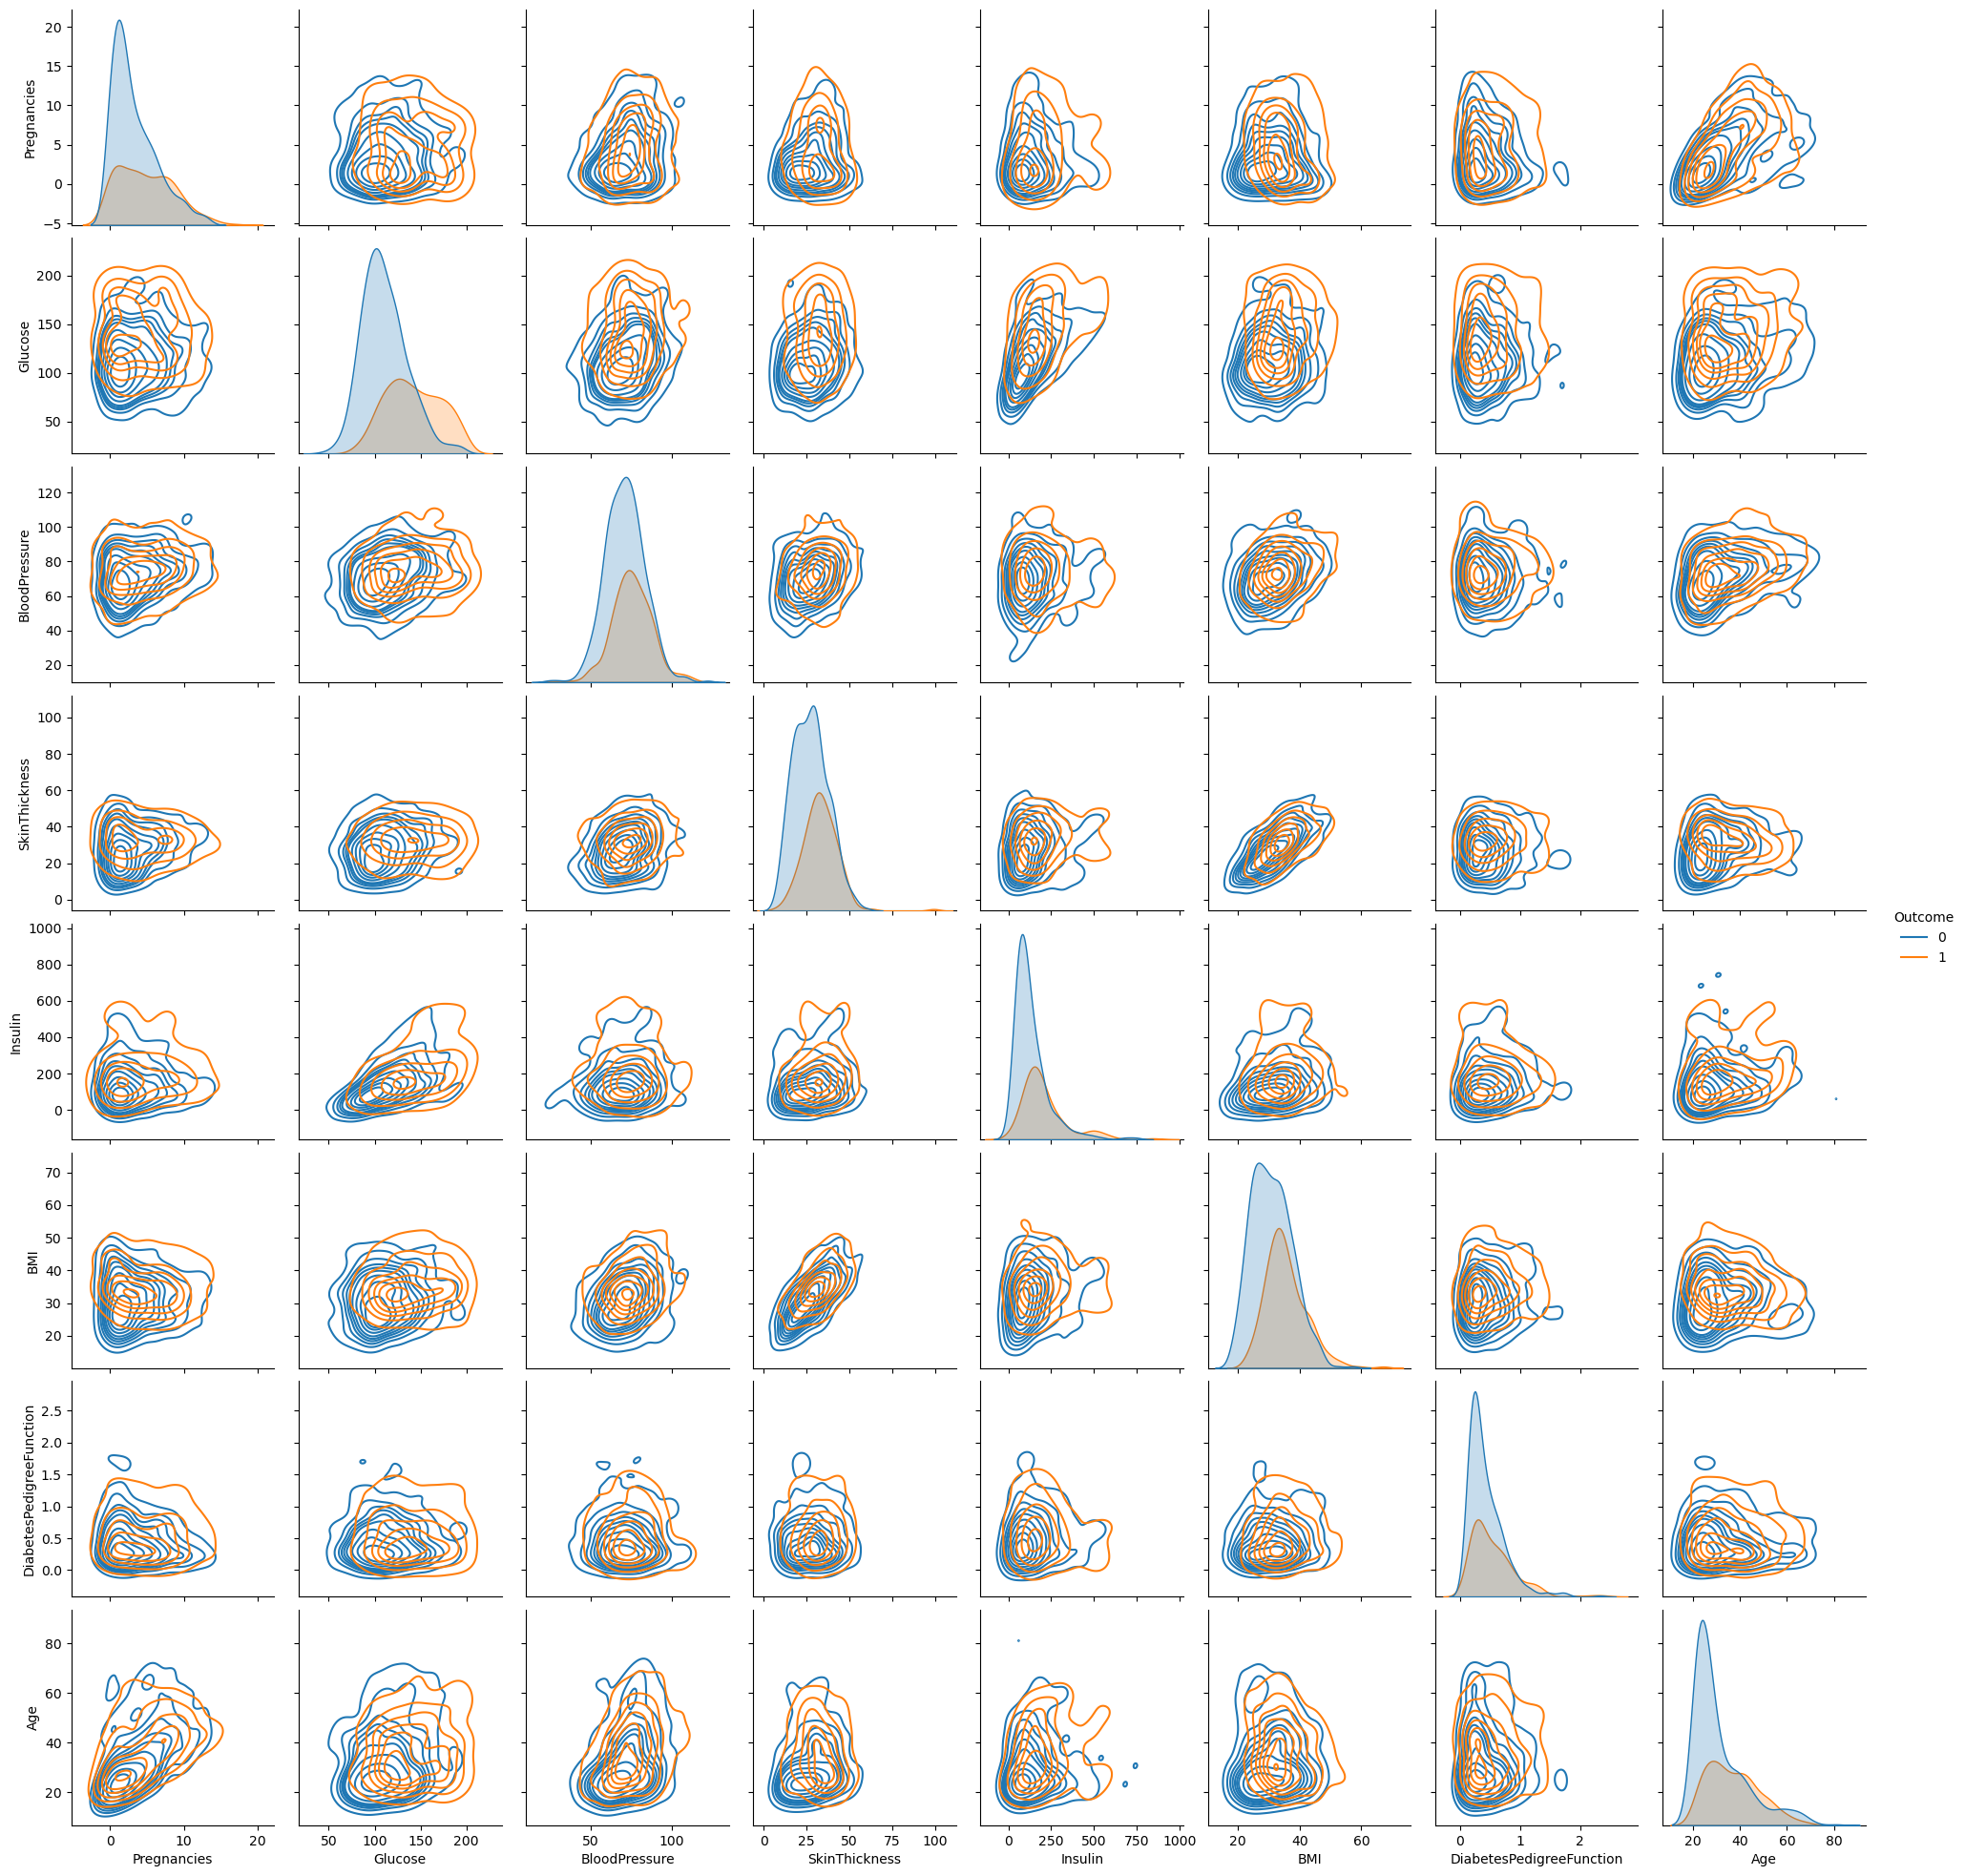

In [22]:
sns.pairplot(diabetesdata, hue='Outcome', kind='kde')

Well, that's not great. All of the blobs are overlapping while KNN works best when there are distinct blobs. However, no need to fear yet! We are only looking at one feature vs one other in each pair in this pair plot. There could still very well be distinct blobs in the full 6D space.

For example, in the image below we see a lot of overlap when considering only two axes, but if we look at the 3D view we can see there is no overlap at all.

![The left shows overlapping point while the right shows a 3D view where things do not overlap](../data/overlapping.png)

So pair plots are great for confirming that KNN might work but not for confirming that KNN will not work. We'll just go ahead.

First, we'll need to do something about the missing values (NaN). We could just drop them:

In [23]:
diabetesdata.dropna()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
6              3     78.0           50.0           32.0     88.0  31.0   
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
..           ...      ...            ...            ...      ...   ...   
753            0    181.0           88.0           44.0    510.0  43.3   
755            1    128.0           88.0           39.0    110.0  36.5   
760            2     88.0           58.0           26.0     16.0  28.4   
763           10    101.0           76.0           48.0    180.0  32.9   
765            5    121.0           72.0           23.0    112.0  26.2   

     DiabetesPedigreeFunction  Age  Outcome  
3                       0.167   21        0  
4                       2.288   33        1  
6                       0.248   26        1  
8                       0.158   53        1  
13                      0.398   59        1  
..                        ...  ...      ...  
753                     0.222   26        1  
755                     1.057   37        1  
760                     0.766   22        0  
763                     0.171   63        0  
765                     0.245   30        0  

[392 rows x 9 columns]

We are left with 392 rows which means we would have just slightly over half of our data remaining, but it would still be a decent size.

In [24]:
print(f"Percentage remaining: {392 / 768 * 100}%")

Percentage remaining: 51.041666666666664%


Another thing we can do is impute which means to try to fill in data for missing values based on intuition or statistical properties. It's basically guessing with style.

We can start with the features that have the least missing values. Those are easier to impute because you already have a lot of information from the existing points so you may be able to infer what the missing value should have been.

In [25]:
diabetesdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


So, Glucose and BMI are the least bad ones because they are only missing a few values. What does BMI look like?

array([[<Axes: title={'center': 'BMI'}>]], dtype=object)

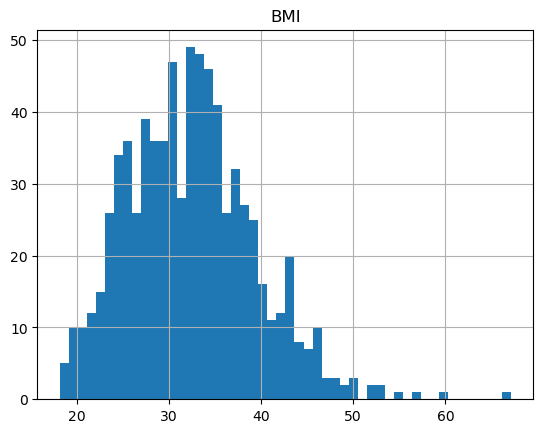

In [26]:
diabetesdata.hist('BMI', bins=50)

Since there are so few missing values it is unlikely to impact the training of the model much. So, we could just replace the missing values with the mean or maybe better, the median since there is a fair number of people with really high BMI.

In [27]:
diabetesdata['BMI'] = diabetesdata['BMI'].fillna(diabetesdata['BMI'].median())

Let's look at the glucose now.

array([[<Axes: title={'center': 'Glucose'}>]], dtype=object)

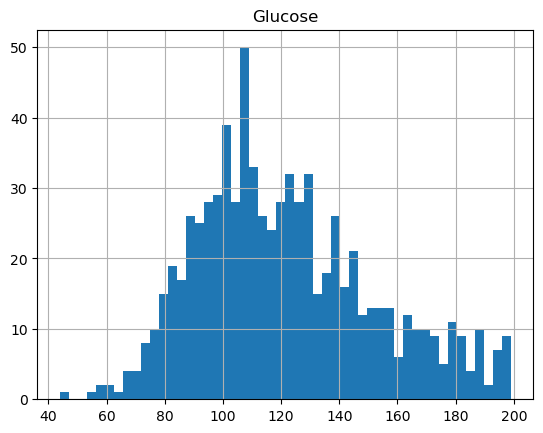

In [28]:
diabetesdata.hist('Glucose', bins=50)

We fill in the missing values with the median again.

In [29]:
diabetesdata['Glucose'] = diabetesdata['Glucose'].fillna(diabetesdata['Glucose'].median())

So how many complete rows do we have now? Let's count the number of rows remaining after dropping the rows containing missing values again.

In [30]:
len(diabetesdata.dropna())

394

We went from 392 complete rows to 394, so we only gained two rows there. The next feature we are interestg in is BloodPressure which has 35 missing values.

array([[<Axes: title={'center': 'BloodPressure'}>]], dtype=object)

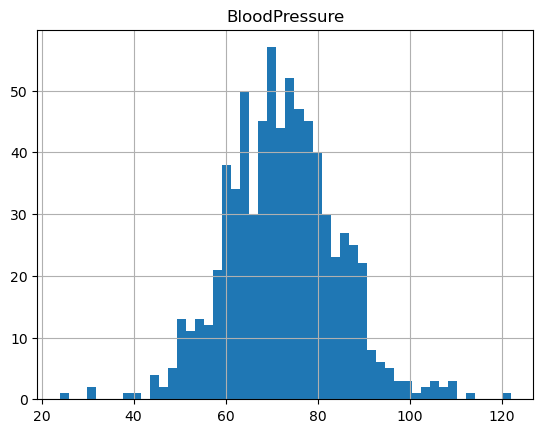

In [31]:
diabetesdata.hist('BloodPressure', bins=50)

We can just use the mean here, but we can also be a bit fancier. It seems likely that a health indicator like blood pressure could be related to other health indicators like BMI or maybe age. Let's plot that along with a linear regression to show the relation.

<Axes: xlabel='BloodPressure', ylabel='BMI'>

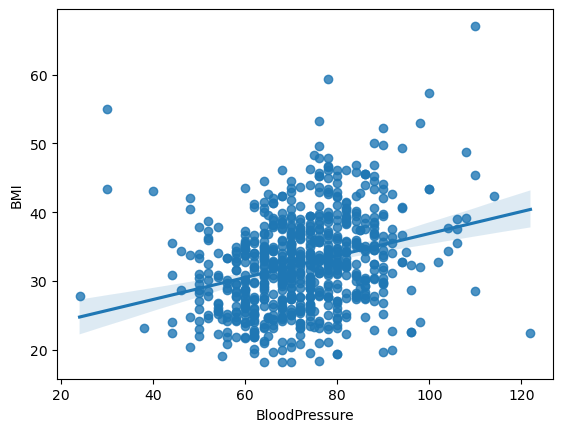

In [32]:
sns.regplot(x = 'BloodPressure', y = 'BMI', data = diabetesdata)

<Axes: xlabel='BloodPressure', ylabel='Age'>

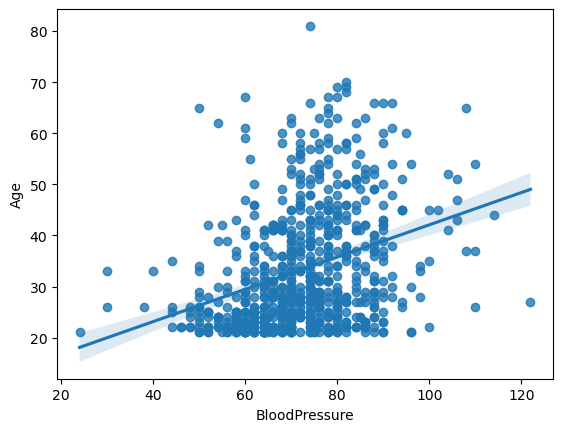

In [33]:
sns.regplot(x = 'BloodPressure', y = 'Age', data = diabetesdata)

It's not entirely clear although there seems to be some relation. Let's use a linear regression to estimate values. We are using machine learning to impute so we can do better machine learning!

Let's drop the missing values from BloodPressure so we can do the regression on the remaining data. We create a new variable, `linearregressiondata`, to store our data specifically for creating a linear regression model that we can then use with the original dataset to fill in the missing data.

In [34]:
linearregressiondata = diabetesdata.dropna(subset='BloodPressure')
linearregressiondata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 733 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               733 non-null    int64  
 1   Glucose                   733 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             539 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       733 non-null    float64
 6   DiabetesPedigreeFunction  733 non-null    float64
 7   Age                       733 non-null    int64  
 8   Outcome                   733 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 57.3 KB


We have two columns, SkinThickness and Insulin, that are still incomplete. For machine learning, we need complete rows. Would insulin and skin thickness be related to blood pressure? Maybe, but then we can't fill in the data. So lets just disregard those columns and do the linear regression on the remaining ones.

In [35]:
linregcolumns = ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = linearregressiondata[linregcolumns]
y = linearregressiondata['BloodPressure']
model.fit(X, y)

LinearRegression()

Cool, now let's apply this model to the rows that are missing the blood pressure.

In [36]:
missingbloodpressure = diabetesdata[pd.isna(diabetesdata['BloodPressure'])]
bloodpred = model.predict(missingbloodpressure[linregcolumns])
bloodpred

array([73.93919638, 70.43554838, 69.82130944, 67.43011138, 75.72758182,
       67.80630365, 65.98555148, 85.29475279, 70.89036191, 69.2958976 ,
       70.83444983, 69.59476835, 71.64088114, 82.09136259, 74.36202586,
       65.34034314, 80.51618983, 68.78238338, 64.10474537, 76.73269019,
       76.19487501, 73.76001417, 77.37352951, 68.01409313, 70.85614871,
       69.52508808, 70.39727244, 62.35302028, 66.57881594, 74.10097232,
       69.73632448, 68.06996674, 64.5521442 , 77.9464623 , 72.48189817])

Well, those look like reasonable values since they are in a similar range as the non-missing values. Let's copy those to the original dataset and replace the missing values with the above predictions.

In [37]:
diabetesdata.loc[pd.isna(diabetesdata['BloodPressure']), 'BloodPressure'] = bloodpred

And now we have BloodPressure filled in with reasonable values.

In [38]:
diabetesdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


array([[<Axes: title={'center': 'BloodPressure'}>]], dtype=object)

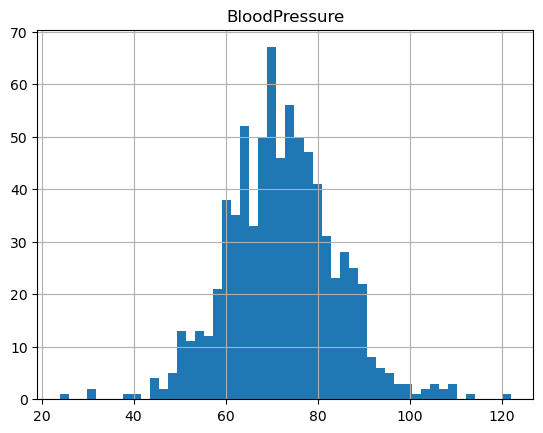

In [39]:
diabetesdata.hist('BloodPressure', bins=50)

How many rows do we have now that do not have any missing data?

In [40]:
len(diabetesdata.dropna())

394

So we didn't actually gain anything here. It looks like the missing values for BloodPressure coincide with those for Insulin or SkinThickness. Still, it was educational to do so, so I'm just leaving this in.

What to do about two remaining incomplete columns. It's a bit much to impute maybe. So let's just leave those incomplete columns out. Also, reset the index while we are at it. Not strictly necessary but it looks cleaner and it might prevent subtle issues later on.

In [41]:
diabetesdata.dropna(inplace=True)
diabetesdata.reset_index(inplace=True)
diabetesdata.drop('index', axis=1, inplace=True)

In [42]:
diabetesdata

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              1     89.0           66.0           23.0     94.0  28.1   
1              0    137.0           40.0           35.0    168.0  43.1   
2              3     78.0           50.0           32.0     88.0  31.0   
3              2    197.0           70.0           45.0    543.0  30.5   
4              1    189.0           60.0           23.0    846.0  30.1   
..           ...      ...            ...            ...      ...   ...   
389            0    181.0           88.0           44.0    510.0  43.3   
390            1    128.0           88.0           39.0    110.0  36.5   
391            2     88.0           58.0           26.0     16.0  28.4   
392           10    101.0           76.0           48.0    180.0  32.9   
393            5    121.0           72.0           23.0    112.0  26.2   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.167   21        0  
1                       2.288   33        1  
2                       0.248   26        1  
3                       0.158   53        1  
4                       0.398   59        1  
..                        ...  ...      ...  
389                     0.222   26        1  
390                     1.057   37        1  
391                     0.766   22        0  
392                     0.171   63        0  
393                     0.245   30        0  

[394 rows x 9 columns]

Training time!

In [43]:
X = diabetesdata[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = diabetesdata['Outcome']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.7563025210084033

So that's about 75.6% which isn't too bad but not great either. We did that with $k=5$ but maybe other values would have better results. This is called *Hyperparameter optimization*. That is tuning the parameter of the algorithm itself.

For KNN, it's pretty easy, we can just iterate over various values of $k$ and see what works best. However, Scikit Learn has built-in methods for this as well, so let's just use those.

In [44]:
from sklearn.model_selection import GridSearchCV

We need to specify a range for in witch `GridSearchCV` will look for optimized parameters. We should be doing just odd values of $k$ because it avoids ties when comparing neighbouring points for binary choices (yes/no for diabetes). For example, for $k=4$, if two neighbouring points say yes and two neighbouring points say no, then what do you choose? That problem doesn't occur for odd values of $k$.

Other stuff we can tune is the distance metric. The default is Minkowski which calculates the distance in the "normal" way for $p=2$. That is, $d = \sqrt{x^2 + y^2}$, but you could also have $p=1$ which is "city block" or "Manhattan" where $d = \lvert x \rvert + \lvert y \rvert$. The one for $p=3$ is pretty weird, but why not. That's $d = \sqrt[3]{\lvert x \rvert^3 + \lvert y \rvert^3}$.

We put all these ranges in a variable called `param_grid` which we can then feed for `GridSearchCV`. It will run multiple training sessions to try and find the most optimal parameters. For larger models this could take quite a while. Fortunately KNN is very fast to train.

In [45]:
param_grid = {
    'n_neighbors': range(1,50,2),
    'p': range(1,4)
}

In [46]:
gridsearch = GridSearchCV(neigh, param_grid, scoring='accuracy')
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50, 2), 'p': range(1, 4)},
             scoring='accuracy')

In [47]:
gridsearch.best_params_

{'n_neighbors': 23, 'p': 2}

In [48]:
gridsearch.best_score_

np.float64(0.7745454545454546)

With $k=23$, the KNN model performs slightly better! However, beware that the improvement is very small. If you run this notebook again with a different `random_state` for the `train_test_split`, you might get different outcomes because the test/train set will be split differently every time you specify a different random seed and thus the model results will be slightly different.

In any case, it doesn't seem like we can push this model much higher then 75%. That means it will get it wron 1 out of 4 times which isn't acceptable for something trying to predict a medical condition. It could still be useful when combined with follow-up tests though. It all depends on context.

Another thing to keep in mind is that this model was trained on a very specific group of people so there might be genetics that affect the results too. As always with machine learning, the input data is key to the quality of the model.

# Privacy Survey

The k-nearest neighbour algorithm does not always work. As an example of **failure**, let's look at using KNN to predict responses to survey questions. We will see there is simply not enough correlation between the answers to the other questions and the one we are trying to predict.

## Data
We will use a dataset from the Open Government Portal. In this case, it's the "2022-23 Survey of Canadians on privacy-related issues" based on phone interviews ([Source](https://open.canada.ca/data/en/dataset/897a64fd-619d-48cc-b056-c9f6484b63b1)).

Suppose we want to classify our respondents based on the answers they give. KNN could be a good algorithm for this since the answers to the questions would hopefully put people in neat boxes as all the questions are somewhat related to each other.

KNN is a supervised learning algorithm though which means it needs to have labels to learn from. One approach is to have a bunch of group members label a bunch of the surveys manually and then have the rest of the surveys be classified by the KNN algorithm. It's a lot less work than labelling them all manually.

However, we don't want to go into that. Instead we'll just use one of the questions as a label. One of the questions is "In general, are you concerned about the protection of your privacy?". We want to predict the answer to this question based on the answers to all of the other questions. This is still useful because if you can predict this question with near-100% accuracy, then you don't really need to include this question in subsequent surveys and thus make it shorter and more likely for people to complete.

In [49]:
survey = pd.read_csv('../data/MLTS_20241205_KNN_2022-23_survey_canadians_dataset_1.0.csv')
survey

QUEST  STYPE LANG  QF  Q1  Q2  Q3A  Q3B Q4A Q4B  ...  Q20M1  Q20M2  \
0        228      2   EN   6   4   7    2    2       2  ...      2          
1        349      2   FR   5   1   5    5    5   4      ...      2          
2       1019      2   EN   5   2   7    5    5   6      ...      1          
3       1109      2   FR   5   1   7    7    7       7  ...      2          
4       1208      2   EN  10   2   7    6    6       5  ...      1          
...      ...    ...  ...  ..  ..  ..  ...  ...  ..  ..  ...    ...    ...   
1495  263855      1   EN   2   1   3    3    1   2      ...      1          
1496  263883      1   EN   2   1   7    4    4   4      ...      1          
1497  263889      1   EN   2   2   6    5    3   4      ...      1          
1498  263926      1   EN   2   2   7    4    4       6  ...      1          
1499  264106      1   EN   2   3   3    3    4       2  ...      1          

      Q20M3  Q21  Q22  Q23  Q24  AGE_COL  REGION    WEIGHT  
0              2    2    1    4        3       3  1.470245  
1              2    2    1    7        3       2  0.853297  
2              2   99   99    7        2       2  1.578553  
3              2    2    1    7        3       2  0.853297  
4              2   99    2    3        3       5  1.068920  
...     ...  ...  ...  ...  ...      ...     ...       ...  
1495           2    2    2    1        4       1  0.378720  
1496           2    2   99    4        3       1  0.811720  
1497           2    2    2    2        4       1  0.378720  
1498           2    2    2    6        4       1  0.378720  
1499           2    2    2    6        4       1  0.378720  

[1500 rows x 54 columns]

This is extremely cryptic data. Fortunately, there is a data dictionary that comes with this data set which you can view in the file "2022-23_survey_canadians_dictionary.csv". The question we want to predict is Q2. The answers range from 1 to 7 but other options are 98 (don't know) and 99 (refused). Let's drop those 98 and 99 responses.

In [50]:
survey = survey[survey['Q2'] <= 7]

Let's corrolate this with the answers from a bunch of other questions, for example:

* 3A. How would you rate your knowledge of your privacy rights?
* 3B. How would you rate your knowledge of how to protect your privacy rights?
* 4A. How much you agree or disagree with the following statements: I feel that businesses in general respect my privacy rights. How much you agree or disagree with the following statements: I feel that businesses in general respect my privacy rights.
* 4B. How much you agree or disagree with the following statements: I feel that the Government of Canada in general respects my privacy rights.
* 4C. How much you agree or disagree with the following statements: I am confident that I have enough information to know how new technologies might affect my personal privacy.
* 4D. Do you know what to do if you receive a notification from an organization about a privacy breach?

Looking closer at Q4A and Q4B by just looking at the table above, they seem to be mutually exclusive. Let's confirm that. Pandas lets you do boolean operations and with `sum` it will tell you the number of times `True` occurs.

In [51]:
sum((survey['Q4A'] != ' ') & (survey['Q4B'] != ' '))

0

So it looks like people got either question 4A or 4B but not both. The difference is that 4A asks about government and 4B asks about business. So what to do here?

We can merge them and assume people that people will trust governments and business in equal measure. Or we can create two separate data sets, one with government and one with business.

The one thing we cannot do is to just set it to zero because KNN will look at the nearest neighbours. This would just group people that didn't get 4A close to people that answered 1 on question 4B.

We'll go with the merging:

In [52]:
survey = survey.assign(Q4AB=(survey['Q4A'] + survey['Q4B']).astype('int'))

Let's get rid of the other "Don't know" and "Refused" answers

In [53]:
survey = survey[(survey['Q3A'] <= 7) & (survey['Q3B'] <= 7) & (survey['Q4AB'] <= 7) & (survey['Q4C'] <= 7) & (survey['Q4D'] <= 7)]

Let's look at the pairplot again to see if we can get similar patterns as with the Penguins dataset that can be distinguished.

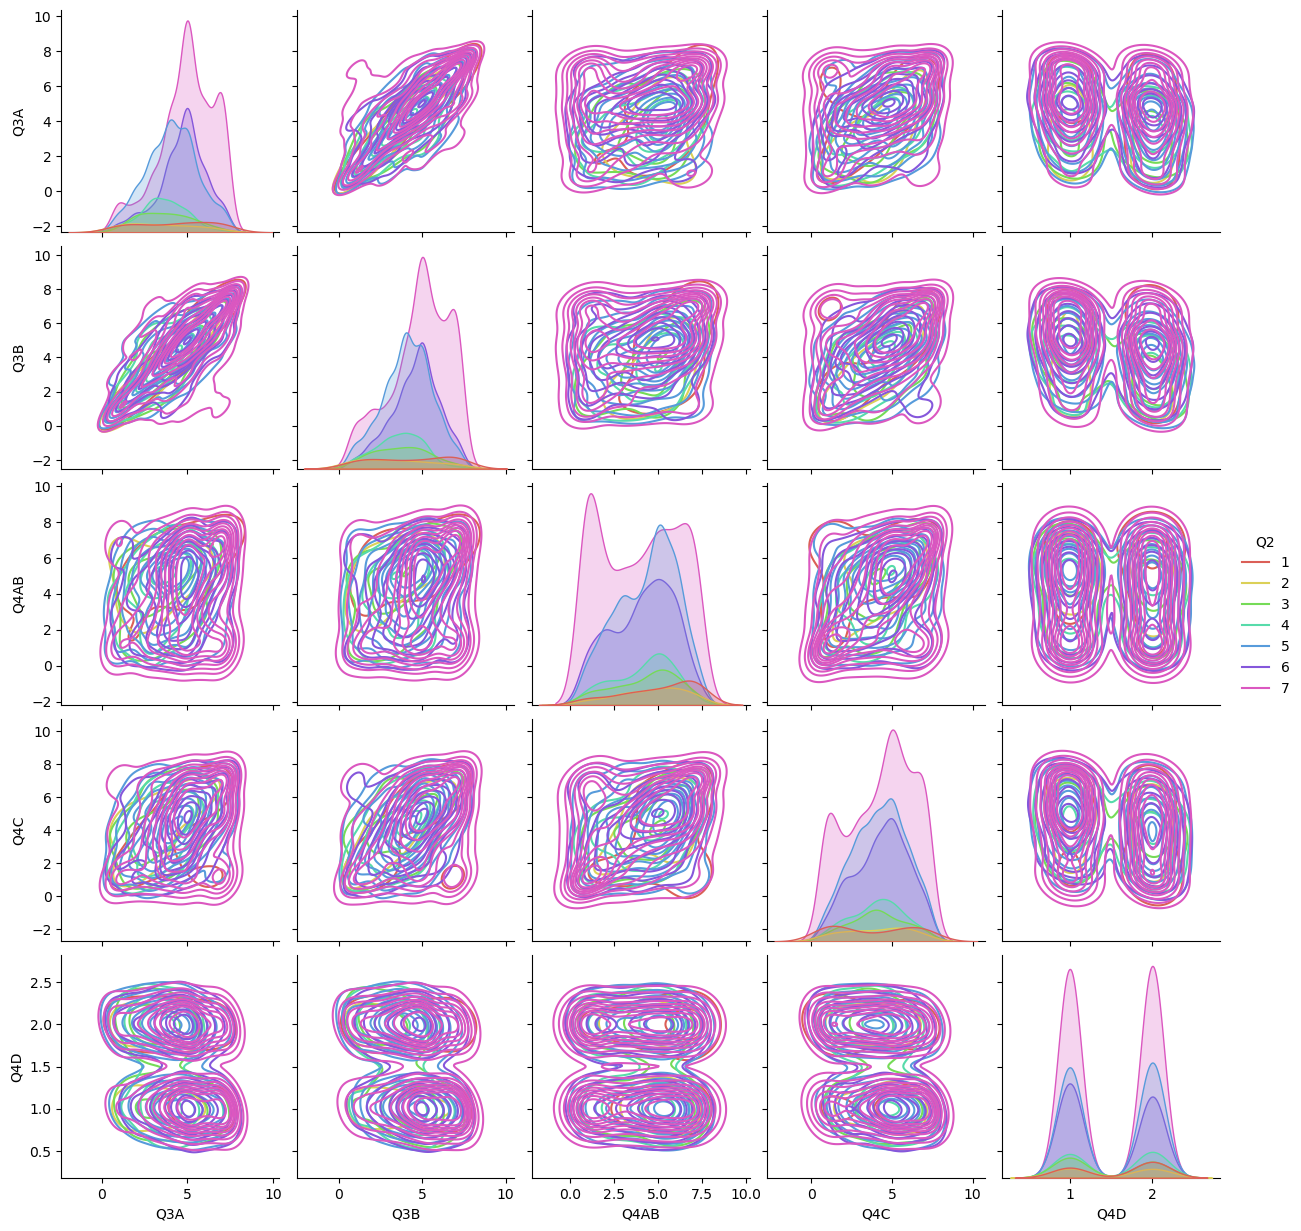

In [54]:
sns.pairplot(survey[['Q3A', 'Q3B', 'Q4AB', 'Q4C', 'Q4D', 'Q2']], hue='Q2', kind="kde", palette=sns.color_palette('hls',7))

Well, that does not look promising. There doesn't seem to be any relation. Just a tiny bit in Q3A and Q3B. Let's try it anyway and see what happens. However, as we saw before with the diabetes dataset, this doesn't necessarily mean that there is no hope at all. In this case we have fewer features though so it does not bode well.

In [55]:
X = survey[['Q3A', 'Q3B', 'Q4AB', 'Q4C', 'Q4D']]
y = survey['Q2']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.32235294117647056

That is only a 32% accuracy which is not great! This tells us that the question "2. In general, are you concerned about the protection of your privacy?" does not really depend on the answers to the other questions that we picked. It appears to indeed be an independent question, so we cannot use KNN in this case since there is not a strong enough relation.

# Book genres

This is another example of **failure**. This probably didn't work out because of the *curse of dimensionality* which says that if your input data has a very high number of dimensions (in this case a 74000 word input vector!) and a lot of those columns are actually mostly random, than that essentially guarantees that points will just be very far from each other even if some columns are relevant.

See the Naive Bayes tutorial for an example of a machine learning algorithm where this dataset will work. For now, let's go through the steps of preparing the data.
## Data
We will use the CMU Book Summary Dataset at https://www.cs.cmu.edu/~dbamman/booksummaries.html. It is included in this repository.

This dataset is tab separated without a header row. Column names comes from the accompying README. We'll read the data using Pandas.

In [56]:
books = pd.read_csv('../data/MLTS_20241205_KNN_booksummaries_1.0.txt', sep="\t", header=0, names=['wikipedia', 'freebase', 'title', 'author', 'publicationdate', 'genres', 'summary'])

This dataset contains a number of rows with missing data. However, there are so many books that we can simply drop the incomplete rows and not worry about not having enough data. KNN works better with moderately-sized datasets anyway. That is, several thousands or tens of thousands of rows. I depends a lot on your processing power and memory you have available.

In [57]:
books = books.dropna()
books.head()

wikipedia  freebase                            title                author  \
0        843   /m/0k36               A Clockwork Orange       Anthony Burgess   
1        986   /m/0ldx                       The Plague          Albert Camus   
4       2152   /m/0x5g   All Quiet on the Western Front  Erich Maria Remarque   
5       2890  /m/011zx             A Wizard of Earthsea     Ursula K. Le Guin   
7       4081  /m/01b4w  Blade Runner 3: Replicant Night           K. W. Jeter   

  publicationdate                                             genres  \
0            1962  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
1            1947  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
4      1929-01-29  {"/m/098tmk": "War novel", "/m/016lj8": "Roman...   
5            1968  {"/m/0dwly": "Children's literature", "/m/01hm...   
7      1996-10-01  {"/m/06n90": "Science Fiction", "/m/014dfn": "...   

                                             summary  
0   Alex, a teenager living in near-future Englan...  
1   The text of The Plague is divided into five p...  
4   The book tells the story of Paul Bäumer, a Ge...  
5   Ged is a young boy on Gont, one of the larger...  
7   Living on Mars, Deckard is acting as a consul...

Genres are in a JSON format, so we will need the JSON package to extract those.

In [58]:
import json

Convert that JSON into a simple list. We don't care about the weird identifiers so we'll only use the values and not the keys of the JSON dictionaries.

In [59]:
def genre(row):
    g = json.loads(row.genres)
    return list(g.values())

genresperbook = books.apply(genre, axis=1)
books = books.assign(genres=genresperbook)

The genres column should now be replaced with a list of genres instead of JSON data.

In [60]:
books.head()

wikipedia  freebase                            title                author  \
0        843   /m/0k36               A Clockwork Orange       Anthony Burgess   
1        986   /m/0ldx                       The Plague          Albert Camus   
4       2152   /m/0x5g   All Quiet on the Western Front  Erich Maria Remarque   
5       2890  /m/011zx             A Wizard of Earthsea     Ursula K. Le Guin   
7       4081  /m/01b4w  Blade Runner 3: Replicant Night           K. W. Jeter   

  publicationdate                                             genres  \
0            1962  [Science Fiction, Novella, Speculative fiction...   
1            1947  [Existentialism, Fiction, Absurdist fiction, N...   
4      1929-01-29                          [War novel, Roman à clef]   
5            1968  [Children's literature, Fantasy, Speculative f...   
7      1996-10-01             [Science Fiction, Speculative fiction]   

                                             summary  
0   Alex, a teenager living in near-future Englan...  
1   The text of The Plague is divided into five p...  
4   The book tells the story of Paul Bäumer, a Ge...  
5   Ged is a young boy on Gont, one of the larger...  
7   Living on Mars, Deckard is acting as a consul...

## Feature extraction
Unlike the penguins, we now want to predict multiple labels. One way we can do this is by creating a dummy column like we did for the islands before. Now we need a dummy column for each genre.

The following code does that. It's fairly dark magic and, full transparency, I just copied it mostly from StackOverflow, but what it does is that it takes the lists in the genres column and converts them to a Pandas Series. Then it stacks them one on the other while keeping the main index but with a sub index for each genre per book. Then we get the dummies for that. The result of that is still a multi-index DataFrame but now with a column for every genre per book per listed genre for that book.

We need to collapse that back into a single-index DataFrame again, so we group all that by the first index of our multi-index DataFrame which is the index for the books. We sum on that which means that per book we now have a single row that has a 1 if that book is part of a certain genre and 0 if not. Then we add a prefix to the column name.

In [61]:
dummies = books.genres.apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('genre_')
books = books.join(dummies)

In [62]:
books

wikipedia    freebase                            title  \
0            843     /m/0k36               A Clockwork Orange   
1            986     /m/0ldx                       The Plague   
4           2152     /m/0x5g   All Quiet on the Western Front   
5           2890    /m/011zx             A Wizard of Earthsea   
7           4081    /m/01b4w  Blade Runner 3: Replicant Night   
...          ...         ...                              ...   
16548   36372465  /m/02vqwsp                   The Third Lynx   
16550   36534061   /m/072y44                   Remote Control   
16554   37054020  /m/04f1nbs                Transfer of Power   
16555   37122323  /m/0n5236t                          Decoded   
16557   37159503   /m/073nkd                        Poor Folk   

                     author publicationdate  \
0           Anthony Burgess            1962   
1              Albert Camus            1947   
4      Erich Maria Remarque      1929-01-29   
5         Ursula K. Le Guin            1968   
7               K. W. Jeter      1996-10-01   
...                     ...             ...   
16548          Timothy Zahn            2007   
16550            Andy McNab            1997   
16554           Vince Flynn      2000-06-01   
16555                 Jay-Z      2010-11-16   
16557    Fyodor Dostoyevsky            1846   

                                                  genres  \
0      [Science Fiction, Novella, Speculative fiction...   
1      [Existentialism, Fiction, Absurdist fiction, N...   
4                              [War novel, Roman à clef]   
5      [Children's literature, Fantasy, Speculative f...   
7                 [Science Fiction, Speculative fiction]   
...                                                  ...   
16548                                  [Science Fiction]   
16550                      [Thriller, Fiction, Suspense]   
16554                                [Thriller, Fiction]   
16555                                    [Autobiography]   
16557            [Epistolary novel, Speculative fiction]   

                                                 summary  \
0       Alex, a teenager living in near-future Englan...   
1       The text of The Plague is divided into five p...   
4       The book tells the story of Paul Bäumer, a Ge...   
5       Ged is a young boy on Gont, one of the larger...   
7       Living on Mars, Deckard is acting as a consul...   
...                                                  ...   
16548   The story starts with former government agent...   
16550   The series follows the character of Nick Ston...   
16554   The reader first meets Rapp while he is doing...   
16555   The book follows very rough chronological ord...   
16557   Makar Devushkin and Varvara Dobroselova are s...   

       genre_Absurdist fiction  genre_Adventure  genre_Adventure novel  ...  \
0                            0                0                      0  ...   
1                            1                0                      0  ...   
4                            0                0                      0  ...   
5                            0                0                      0  ...   
7                            0                0                      0  ...   
...                        ...              ...                    ...  ...   
16548                        0                0                      0  ...   
16550                        0                0                      0  ...   
16554                        0                0                      0  ...   
16555                        0                0                      0  ...   
16557                        0                0                      0  ...   

       genre_Utopian fiction  genre_Vampire fiction  genre_War novel  \
0                          0                      0                0   
1                          0                      0                0   
4                          0                      0   

Phew!! Now the data is in a form we can use for the labels.

Let's look a bit closer at the genres and in particular how many books we have in each category. We'll just sum the dummy columns for genres.

In [63]:
genreusage = books.drop(['wikipedia', 'freebase', 'author', 'publicationdate', 'genres', 'title', 'summary'], axis=1).sum().sort_values(ascending=False)
genreusage

genre_Fiction                3674
genre_Speculative fiction    3270
genre_Novel                  2088
genre_Science Fiction        2001
genre_Fantasy                1863
                             ... 
genre_Prose poetry              1
genre_Robinsonade               1
genre_Superhero fiction         1
genre_Utopian fiction           1
genre_Treatise                  1
Length: 215, dtype: int64

So there are a whole bunch of genres that only have one book in the dataset. As you can imagine, this is not going to work well when training the model. So let's put in a lower limit of say 200. How many genres do we have still?


In [64]:
genreusage = genreusage.reset_index().rename(columns={0: "count"})
genreusage = genreusage[genreusage["count"] > 200]
genreusage

index  count
0                  genre_Fiction   3674
1      genre_Speculative fiction   3270
2                    genre_Novel   2088
3          genre_Science Fiction   2001
4                  genre_Fantasy   1863
5    genre_Children's literature   1627
6                  genre_Mystery    973
7   genre_Young adult literature    625
8            genre_Crime Fiction    557
9         genre_Historical novel    551
10                genre_Suspense    538
11                genre_Thriller    429
12                  genre_Horror    383
13           genre_Romance novel    316
14      genre_Historical fiction    314
15         genre_Adventure novel    268

So we have 16 genres that we may be able to distinguish. Let's make an ordinary Python list out of that so we can loop over it later.

In [65]:
genretrainlist = list(genreusage["index"])
genretrainlist

['genre_Fiction',
 'genre_Speculative fiction',
 'genre_Novel',
 'genre_Science Fiction',
 'genre_Fantasy',
 "genre_Children's literature",
 'genre_Mystery',
 'genre_Young adult literature',
 'genre_Crime Fiction',
 'genre_Historical novel',
 'genre_Suspense',
 'genre_Thriller',
 'genre_Horror',
 'genre_Romance novel',
 'genre_Historical fiction',
 'genre_Adventure novel']

In [66]:
dummies = dummies[genretrainlist]

## Input
Next is the input. These are the summaries for a book which is essentially a collection of words. We can vectorize that by making a vector that has a length of however many unique words there are in all the summaries combined. Then each book summary can be represented as a vector that counts the number of words.

That sounds complicated to do, but fortunately, Scikit can do it for us.

In [67]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [68]:
# Create the vectorizer
count_vect = CountVectorizer()

In [69]:
# Apply the vectorizer to the book summaries
X = count_vect.fit_transform(books.summary)

The result if a large matrix with a column for each of the unique words in the entire corpus. The rows contain how often each word is used in a book summary. As you can imagine, this will mean a lot of zeros since it is unlikely that a single book summary will contain at least one of every possible word in the entire corpus. The vectorizer therefore creates a "sparse matrix" instead which is a format that only stores non-zero elements which is much more memory efficient for matrices with large numbers of zeros.

In [70]:
X[0]

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 486 stored elements and shape (1, 90759)>

We'll then convert the counts into frequencies which are numbers between 0 and 1 just as KNN likes it.

In [71]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

## Train

As before, we can train the KNN model as we did before. However, let's just try a bunch of different values for $k$, ranging from 5 to 55. To evaluate the accuracy, we'll look at the accuracy score but also the Hamming loss which shows the fraction of labels that were misassigned. It's between 0 and 1 where lower is better.

In [72]:
y = dummies

scaler = MaxAbsScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

for k in range(5, 56, 10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print(f"k = {k}")
    print(accuracy_score(y_test, y_pred))
    print(hamming_loss(y_test, y_pred))
    print()

k = 5
0.013988522238163558
0.1568328550932568

k = 15
0.004662840746054519
0.20399928263988523

k = 25
0.04770444763271162
0.14125269010043043

k = 35
0.07065997130559541
0.13553622668579626

k = 45
0.08142037302725968
0.13138898852223815

k = 55
0.08034433285509325
0.13132173601147776



The accuracy increases a bit with increasing $k$ but it barely exceeds 8% which is pretty poor. However, only 13% of the labels are misassigned according to the Hamming loss, so that is a bit odd.

The trouble here is that the accuracy score is only considered to be correct if every single label is correctly predicted as yes or no for a book. So if a book is part of 4 genres but the KNN model predicts that it's also part of another genre, than it's considered to be inaccurate even though that's not really that bad.

Since accuracy isn't telling the whole story, let's just pick our model for $k=35$ and work with that. It's a fair number, given the number of data rows we have. Feel free to use any other number though.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=35)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

As a reminder, these are the genres we are working with:

In [74]:
dummies.columns

Index(['genre_Fiction', 'genre_Speculative fiction', 'genre_Novel',
       'genre_Science Fiction', 'genre_Fantasy', 'genre_Children's literature',
       'genre_Mystery', 'genre_Young adult literature', 'genre_Crime Fiction',
       'genre_Historical novel', 'genre_Suspense', 'genre_Thriller',
       'genre_Horror', 'genre_Romance novel', 'genre_Historical fiction',
       'genre_Adventure novel'],
      dtype='object')

Now let's look per genre if the label was predicted correctly or not. We'll iterate over all of the genres and then we check the accuracy score for all books in the test dataset.

In [92]:
for i in range(0,len(dummies.columns)):
    print(f"{dummies.columns[i]:<30}: {accuracy_score(np.array(y_test.iloc[:,i]), np.array(y_pred[:,i])):.2f}")

genre_Fiction                 : 0.51
genre_Speculative fiction     : 0.65
genre_Novel                   : 0.77
genre_Science Fiction         : 0.78
genre_Fantasy                 : 0.81
genre_Children's literature   : 0.83
genre_Mystery                 : 0.90
genre_Young adult literature  : 0.93
genre_Crime Fiction           : 0.94
genre_Historical novel        : 0.95
genre_Suspense                : 0.94
genre_Thriller                : 0.96
genre_Horror                  : 0.96
genre_Romance novel           : 0.96
genre_Historical fiction      : 0.97
genre_Adventure novel         : 0.97


That is way better. It looks like KNN can predict with stunning accuracy. However, if we look at bit deeper at for example Adventure novel which is index 15 and we look at the confusion matrix we get a different picture. A confusion matrix tell you the  true/false positives/negatives as
$$\left[\begin{array}{cc}\text{True negatives} & \text{False positives} \\ \text{False negatives} & \text{True positives}\end{array}\right]$$


In [93]:
confusion_matrix(np.array(y_test.iloc[:,15]), np.array(y_pred[:,15]))

array([[2712,    0],
       [  76,    0]])

So that is really odd! We have many true negatives, meaning that books not part of the adventure novel genre were correctly classified as not being part of that genre. However, we also have many false negatives, meaning that these books were part of the genre but were classified as not being part of the genre. There are also no positives at all. So the KNN model simply didn't classify any books as belonging to the adventure novel genre!

The reason for the high accuracy earlier was simply that there were so many books that were not part of the adventure novel genre (2712) that the ones that were part of the genre (76) were simply vastly outnumbered.

So watch out with solely relying on the accuracy measurement. It doesn't alway tell the whole story. Accuracy scores generally work best for balanced data where there are roughly equal amount of "yes" and "no" labeled data.

Even if we look at the one for Fiction (index 0), it doesn't work very well.

In [94]:
confusion_matrix(np.array(y_test.iloc[:,0]), np.array(y_pred[:,0]))

array([[846, 829],
       [526, 587]])

It's basically 50:50 for determining if a book belongs is classified as fiction. It's just as good as randomly guessing.

So all in all, the KNN model is not terribly good at it. There are a couple of reasons for it. The main reason is that KNN does not work well when there are too many features, especially if many of those features do not contribute to the classifying and are essentially random noise. Essentially, for every unnecessary feature, more random noise is added to the distance measure causing it to become ever more unreliable.

The other reason is that we didn't do any specific cleaning of the data with regarding to language. This is a complex topic and the subject for the tutorial called "Natural Language Processing", but feel free to continue exploring machine learning in any of the other tutorials listed one [our page](https://uottawa-it-research-teaching.github.io/machinelearning/).